In [2]:
%load_ext autoreload
%autoreload 2

In [145]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from helper_functions import euclidean_distance
from helper_functions import contrastive_loss
from helper_functions import load_arrays
from helper_functions import plot_training
from helper_functions import load_and_split_data
from helper_functions import plot_confusion_matrix
from helper_functions import get_model_predictions
from helper_functions import plot_roc_curve
from helper_functions import plot_prec_rec_curve

# Load and prepare Data

### Load and create fast input pipeline with tf.data.dataset

In [5]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_10000.npz", "npz_datasets/data_y_10000.npz", split_size=80, batch_size=256)

CPU times: user 12.1 s, sys: 2.94 s, total: 15.1 s
Wall time: 15.1 s


# Baseline Model

In [6]:
img_width = 224
img_height = 224

In [7]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(4, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(16, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(32, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [8]:
base_model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0     

In [9]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_1(img_a)
feat_vect_b = base_model_1(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [10]:
#Compile the model 
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [11]:
epochs=10
history_model_1 = model_1.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 10s 218ms/step - loss: 0.3101 - accuracy: 0.4834 - val_loss: 0.2924 - val_accuracy: 0.4744
Epoch 2/10
32/32 [==============================] - 7s 211ms/step - loss: 0.2684 - accuracy: 0.5049 - val_loss: 0.2729 - val_accuracy: 0.4725
Epoch 3/10
32/32 [==============================] - 7s 207ms/step - loss: 0.2538 - accuracy: 0.5328 - val_loss: 0.2687 - val_accuracy: 0.4875
Epoch 4/10
32/32 [==============================] - 7s 209ms/step - loss: 0.2462 - accuracy: 0.5590 - val_loss: 0.2668 - val_accuracy: 0.4963
Epoch 5/10
32/32 [==============================] - 7s 208ms/step - loss: 0.2388 - accuracy: 0.5835 - val_loss: 0.2668 - val_accuracy: 0.4894
Epoch 6/10
32/32 [==============================] - 7s 210ms/step - loss: 0.2322 - accuracy: 0.6114 - val_loss: 0.2674 - val_accuracy: 0.4913
Epoch 7/10
32/32 [==============================] - 7s 212ms/step - loss: 0.2261 - accuracy: 0.6304 - val_loss: 0.2677 - val_accuracy: 0.4800
Epoch

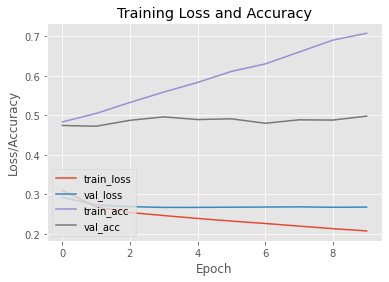

In [12]:
plot_training(history_model_1)

# Evaluate the model

In [112]:
model_1.evaluate(val_dataset)

2/2 [==============================] - 0s 83ms/step - loss: 0.2704 - accuracy: 0.4825


[0.2703598737716675, 0.48249998688697815]

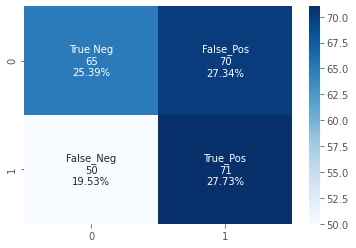

In [141]:
preds, labels = get_model_predictions(val_dataset, model_1)
plot_confusion_matrix(preds, labels)

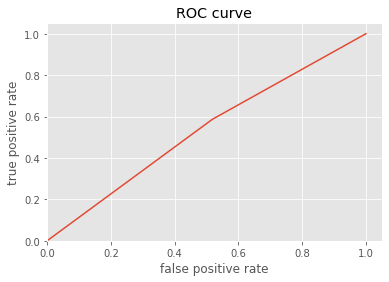

In [157]:
plot_roc_curve(preds, labels)

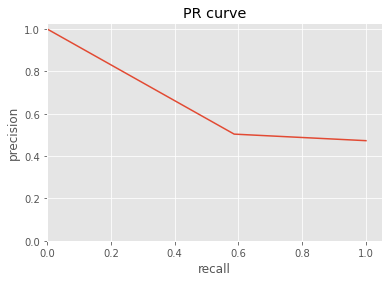

In [149]:
plot_prec_rec_curve(preds, labels)